## Example script for training the L2HMC sampler

## Imports / setup for training

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import datetime
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
try:
    import horovod
    import horovod.tensorflow as hvd
    try:
        RANK = hvd.rank()
    except ValueError:
        hvd.init()
        
    RANK = hvd.rank()
    HAS_HOROVOD = True
    logging.info(f'Using horovod version: {horovod.__version__}')
    logging.info(f'Using horovod from: {horovod.__file__}')
    GPUS = tf.config.experimental.list_physical_devices('GPU')
    for gpu in GPUS:
        tf.config.experimental.set_memory_growth(gpu, True)
    if GPUS:
        gpu = GPUS[hvd.local_rank()]
        tf.config.experimental.set_visible_devices(gpu, 'GPU')
except ImportError:
    HAS_HOROVOD = False

import tensorflow as tf
from rich.console import Console
from rich.theme import Theme
from rich import print

if os.path.abspath('..') not in sys.path:
    sys.path.append(os.path.abspath('..'))
    
sns.set_palette('bright')

plt.style.use('default')
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette('bright')

plt.rc('text', usetex=True)

#console = Console(theme=Theme({"repr.number": "#ff79ff"}),
#                  force_jupyter=True, log_path=False,
#                  width=180, log_time=True, log_time_format='[%X]')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load configs from `BIN_DIR/train_configs.json`:

In [2]:
import json
from config import BIN_DIR

from utils.logger import Logger

logger = Logger()

train_configs_file = os.path.join(BIN_DIR, 'train_configs.json')
with open(train_configs_file, 'rt') as f:
    configs = json.load(f)
    
configs.update({
    'train_steps': 1000,
    'debug': False,
    'run_steps': 5000,
    'save_steps': 200,
    'steps_per_epoch': 200,
    'patience': 5,
    'min_lr': 1e-4,
    'logging_steps': 200,
    'print_steps': 10,
    'beta_init': 3.,
    'beta_final': 3.,
})

configs['dynamics_config'].update({
    'num_steps': 5,
    'x_shape': [64, 16, 16, 2],
    'net_weights': [1., 1., 1., 1., 1., 1.],
})

logger.log(configs)

tf.__version__: 2.5.0


[11:02:59]  {                                                                                
                'log_dir': None,                                                             
                'debug': False,                                                              
                'profiler': False,                                                           
                'md_steps': 10,                                                              
                'beta_init': 3.0,                                                            
                'beta_final': 3.0,                                                           
                'clip_val': 0.0,                                                             
                'loss_scale': 0.1,                                                           
                'hmc_steps': 0,                                                              
                'print_steps': 10,                                                           
                'logging_steps': 200,                                                        
                'steps_per_epoch': 200,                                                      
                'reduce_lr_factor': 0.99,                                                    
                'patience': 5,                                                               
                'min_lr': 0.0001,                                                            
                'save_steps': 200,                                                           
                'run_steps': 5000,                                                           
                'train_steps': 1000,                                                         
                'dynamics_config': {                                                         
                    'verbose': True,                                                         
                    'eps': 0.1,                                                              
                    'num_steps': 5,                                                          
                    'hmc': False,                                                            
                    'use_ncp': True,                                                         
                    'eps_fixed': False,                                                      
                    'aux_weight': 0.0,                                                       
                    'plaq_weight': 0.0,                                                      
                    'charge_weight': 0.01,                                                   
                    'zero_init': False,                                                      
                    'separate_networks': True,                                               
                    'use_conv_net': True,                                                    
                    'use_mixed_loss': False,                                                 
                    'directional_updates': False,                                            
                    'combined_updates': False,                                               
                    'use_scattered_xnet_update': False,                                      
                    'use_tempered_traj': False,                                              
                    'gauge_eq_masks': False,                                                 
                    'x_shape': [64, 16, 16, 2],                                              
                    'log_dir': None,                                                         
                    'optimizer': 'Nadam',                                                    
                    'net_weights': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]                            
                },                                  

Get timestamp and create `log_dir` where everything will live

In [3]:
import utils.file_io as io
from utils.attr_dict import AttrDict

# Keep history of `log_dir` for later reference
log_file = os.path.join(os.getcwd(), 'log_dirs.txt')

configs = AttrDict(configs)

timestamps = AttrDict({
    'month': io.get_timestamp('%Y_%m'),
    'time': io.get_timestamp('%Y-%m-%d-%H%M%S'),
    'hour': io.get_timestamp('%Y-%m-%d-%H'),
    'minute': io.get_timestamp('%Y-%m-%d-%H%M'),
    'second': io.get_timestamp('%Y-%m-%d-%H%M%S'),
})

log_dir = io.make_log_dir(configs, 'GaugeModel', log_file,
                          timestamps=timestamps)
configs.log_dir = log_dir
io.write(f'{configs.log_dir}', log_file, 'a')

0 :: Using tensorflow version: 2.5.0
0 :: Using tensorflow from: /Users/saforem2/opt/anaconda3/envs/tf2.5-torch1.8.1-hvd0.22/lib/python3.9/site-packages/tensorflow/__init__.py
0 :: Using horovod version: 0.22.0
0 :: Using horovod from: /Users/saforem2/opt/anaconda3/envs/tf2.5-torch1.8.1-hvd0.22/lib/python3.9/site-packages/horovod/__init__.py
rank: 0 local_rank: 0 size: 1 local_size: 1


[11:03:03]  Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/2021_06/L16_b6
            4_lf5_actswish_bi3_bf3_dp025_sepNets_NCProj_ConvNets_bNorm_nw111111

            Saving train_configs to /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/2021_06/L1
            6_b64_lf5_actswish_bi3_bf3_dp025_sepNets_NCProj_ConvNets_bNorm_nw111111/train_con
            figs.z.

In [4]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'UserWarning')
warnings.filterwarnings('ignore', 'CustomMaskWarning')
warnings.filterwarnings('ignore', 'WARNING:matplotlib')


## Run training:

To demonstrate that everything is working correctly, we only train for `configs.train_steps = 100` training steps.

In [5]:
configs.train_steps = 10000
configs.print_steps = 10
configs.logging_steps = 500
configs.save_steps = 5000

In [9]:
plt.style.use('/Users/saforem2/.matplotlib/stylelib/molokai.mplstyle')

[11:05:18]  Saving FLAGS to /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/2021_06/L16_b64_lf
            5_actswish_bi3_bf3_dp025_sepNets_NCProj_ConvNets_bNorm_nw111111/training/FLAGS.z.

            Using separate (x, v)-networks for each LF step!!

[11:05:26]  Using separate (x, v)-networks for each LF step!!

[11:05:34]  dynamics.net_weights: NetWeights(x_scale=1.0, x_translation=1.0,                 
            x_transformation=1.0, v_scale=1.0, v_translation=1.0, v_transformation=1.0)

[11:05:34]  Saving dynamics_config to /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/2021_06/
            L16_b64_lf5_actswish_bi3_bf3_dp025_sepNets_NCProj_ConvNets_bNorm_nw111111/trainin
            g/dynamics_configs/dynamics_config.z.

            Saving network_config to /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/2021_06/L
            16_b64_lf5_actswish_bi3_bf3_dp025_sepNets_NCProj_ConvNets_bNorm_nw111111/training
            /dynamics_configs/network_config.z.

            Saving lr_config to /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/2021_06/L16_b6
            4_lf5_actswish_bi3_bf3_dp025_sepNets_NCProj_ConvNets_bNorm_nw111111/training/dyna
            mics_configs/lr_config.z.

            Saving dynamics_params to /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/2021_06/
            L16_b64_lf5_actswish_bi3_bf3_dp025_sepNets_NCProj_ConvNets_bNorm_nw111111/trainin
            g/dynamics_configs/dynamics_params.z.

            Saving config to /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/2021_06/L16_b64_l
            f5_actswish_bi3_bf3_dp025_sepNets_NCProj_ConvNets_bNorm_nw111111/training/dynamic
            s_configs/config.z.

            Unable to save to `.json` file. Continuing...

            Saving conv_config to /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/2021_06/L16_
            b64_lf5_actswish_bi3_bf3_dp025_sepNets_NCProj_ConvNets_bNorm_nw111111/training/dy
            namics_configs/conv_config.z.

──────────────────────────────── [2021-06-21 11:05] TRAINING ────────────────────────────────

───────────────────────── [2021-06-21 11:12] Running 10 MD updates ──────────────────────────

───────────────────────────────── [2021-06-21 11:12] done! ──────────────────────────────────

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[11:12:52]  `get_title_str_from_params` took: 6.51e-05s  (0 min 6.5088272e-05 sec)

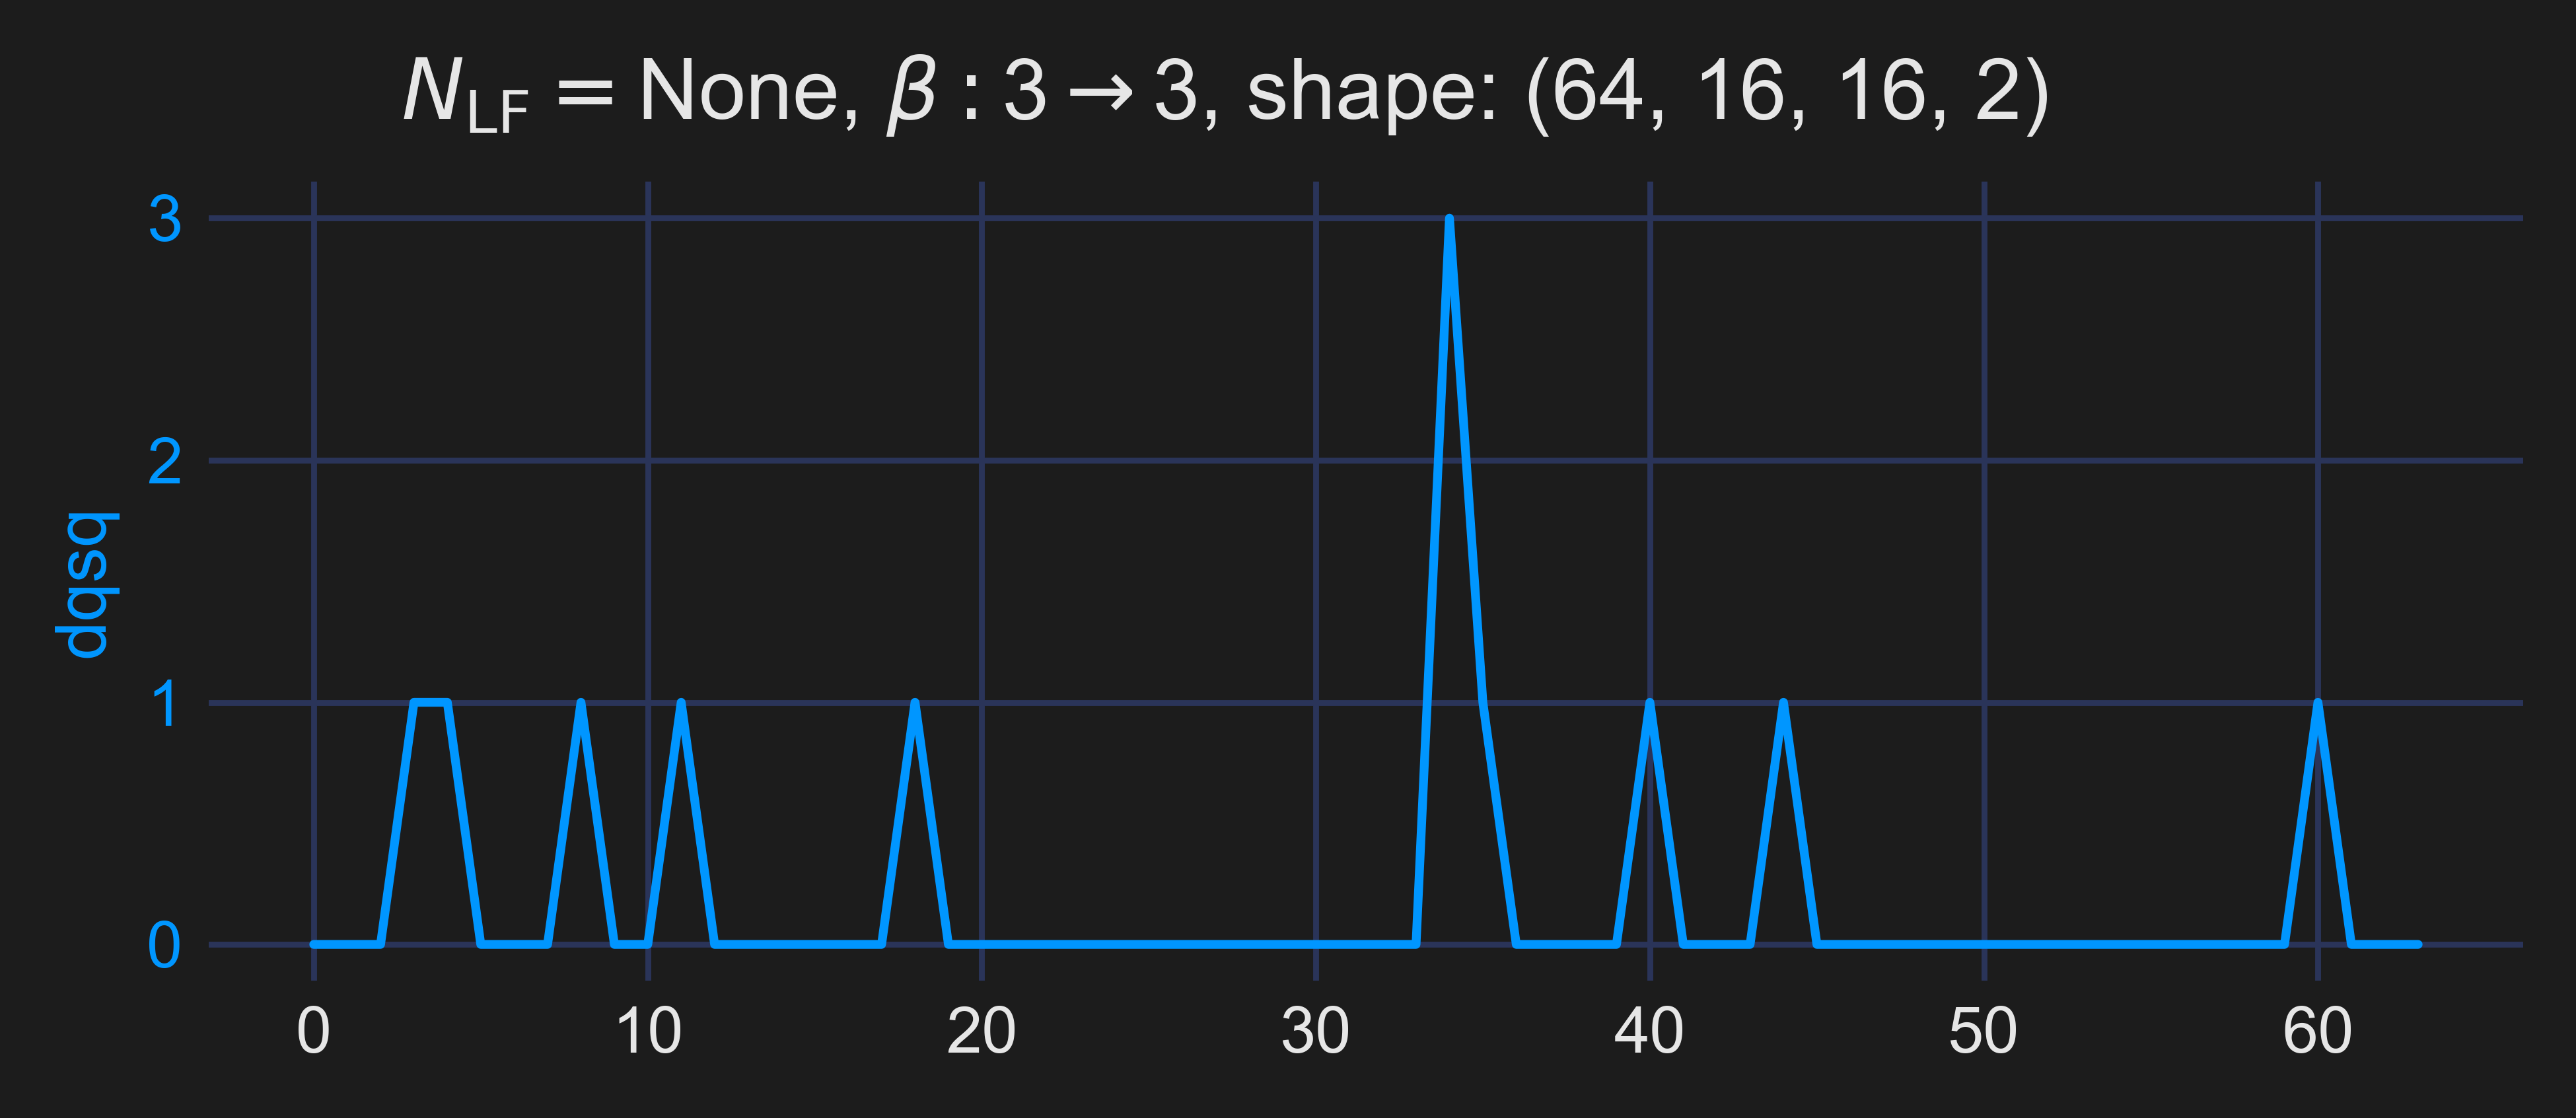

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

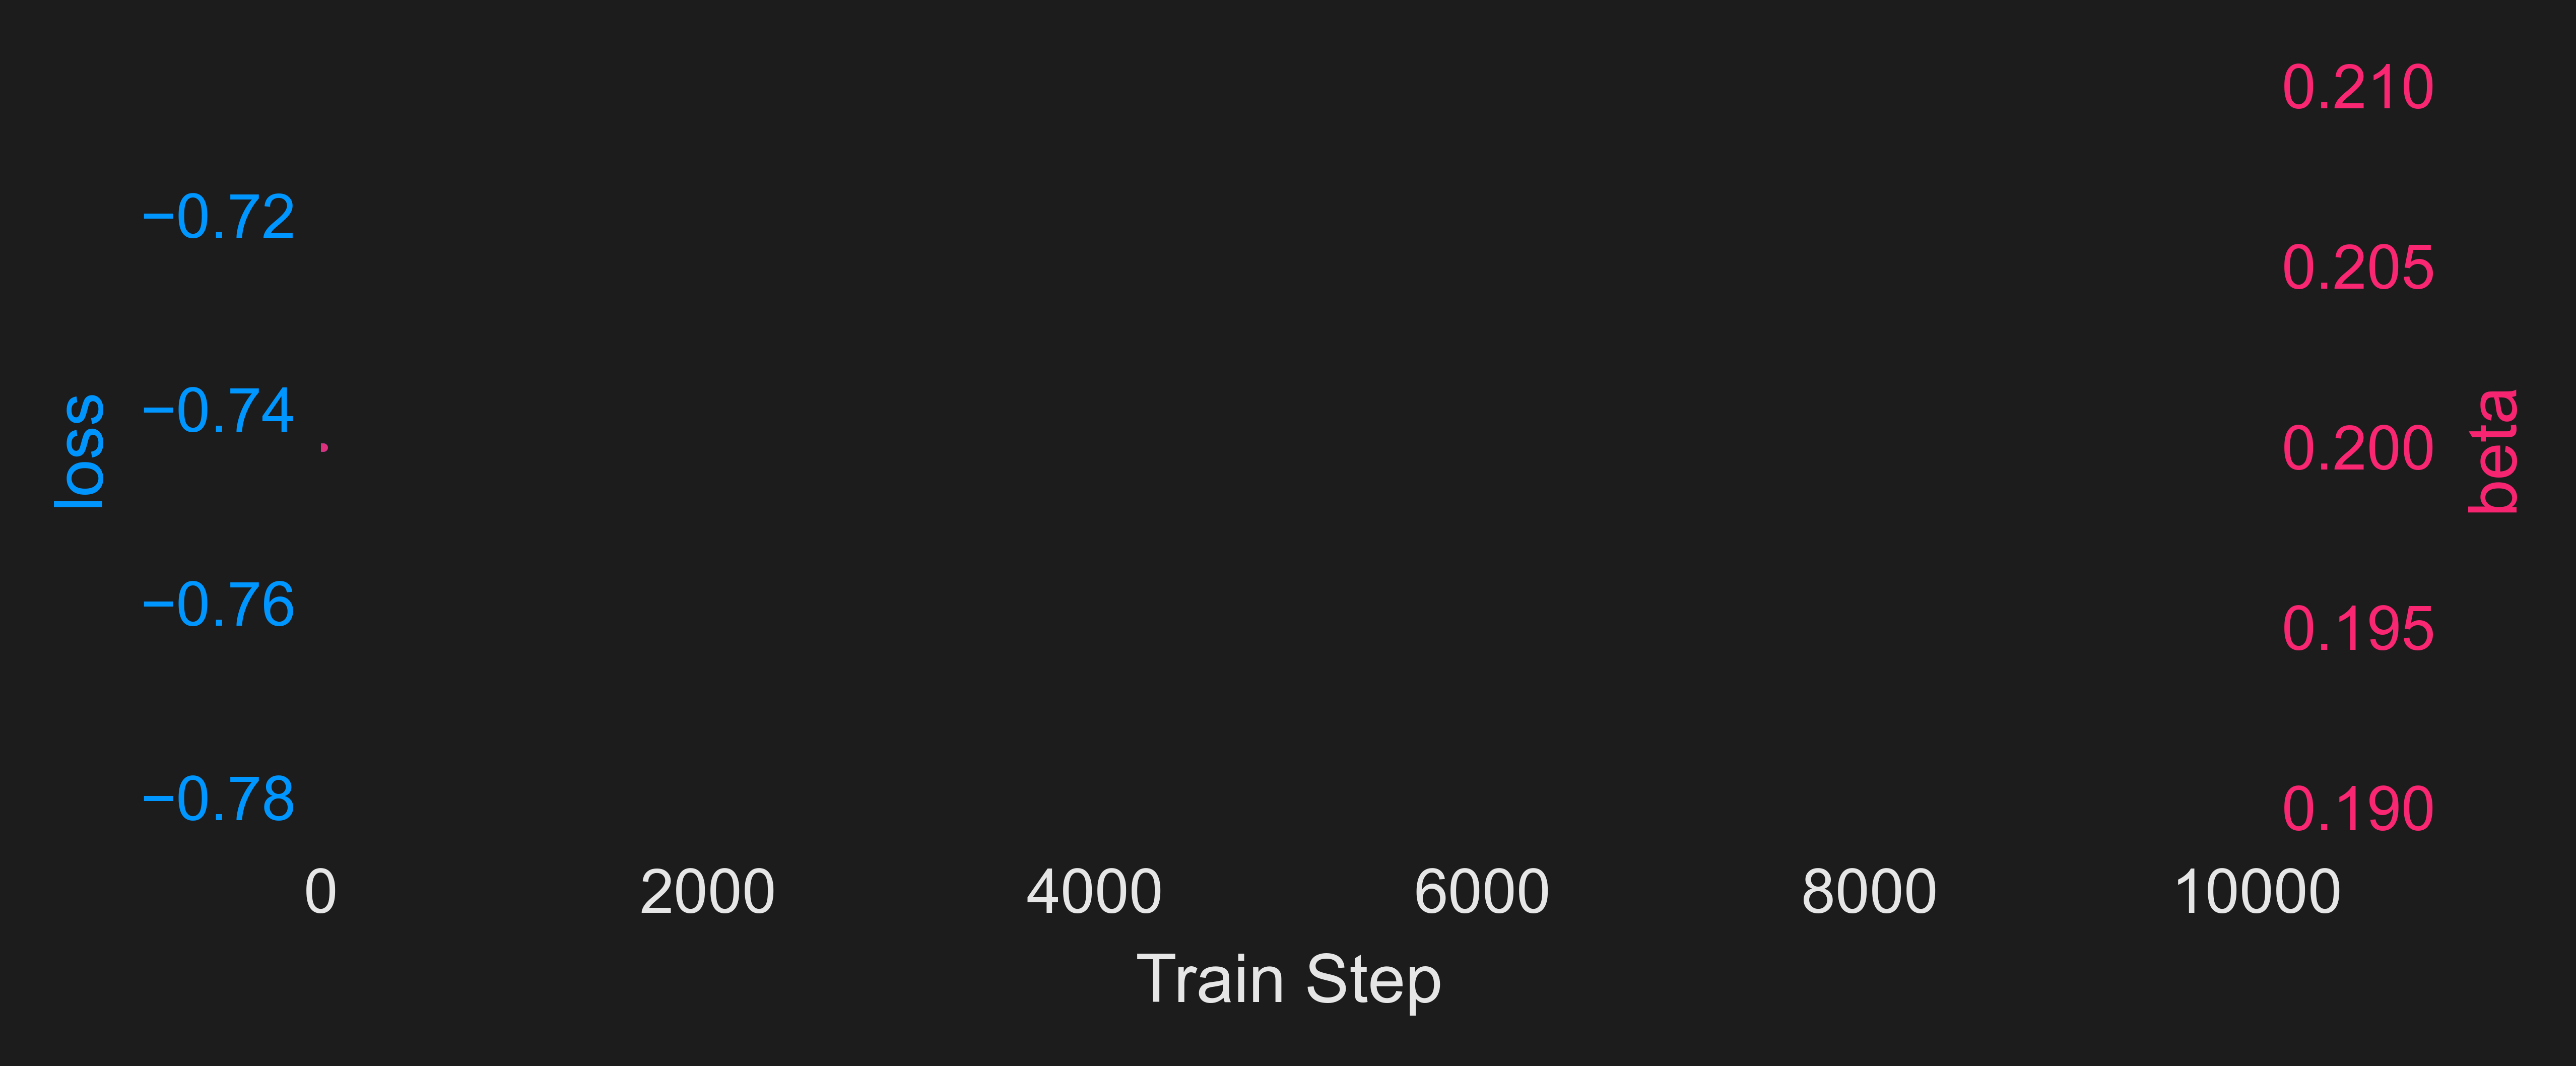

[11:12:56]  step=0/10001 dt=0.3977 loss=-27.02 accept_prob=0.7446 beta=3     xeps=0.1013     
            xeps_start=0.1015 xeps_mid=0.1009 xeps_end=0.1016 veps=0.102 veps_start=0.102    
            veps_mid=0.102 veps_end=0.102 Hwf_start=409   Hwf_mid=409.1 Hwf_end=409.3        
            Hwb_start=412   Hwb_mid=412.2 Hwb_end=412.2 dq_sin=0.3426 charges=0.4062         
            sin_charges=0.2733 plaqs=0.007484 p4x4=-0.004298

[11:13:10]  step=10/10001 dt=0.4121 loss=-15.8 accept_prob=0.6733 beta=3     dq_int=0.08     
            dq_sin=0.2469 plaqs=-0.001216 p4x4=0.01314

[11:13:18]  step=20/10001 dt=0.4537 loss=-16.04 accept_prob=0.7207 beta=3     dq_int=0.18    
            dq_sin=0.3093 plaqs=-0.00287 p4x4=-0.00869

[11:13:26]  step=30/10001 dt=0.4466 loss=-10.26 accept_prob=0.6642 beta=3     dq_int=0.22    
            dq_sin=0.2389 plaqs=-0.002487 p4x4=-0.005155

[11:13:35]  step=40/10001 dt=0.4672 loss=-21.47 accept_prob=0.5486 beta=3     dq_int=0.12    
            dq_sin=0.258 plaqs=-0.002521 p4x4=-0.007715

[11:13:44]  step=50/10001 dt=0.524 loss=-12.29 accept_prob=0.6172 beta=3     dq_int=0.22     
            dq_sin=0.2219 plaqs=0.001357 p4x4=0.004337

[11:13:54]  step=60/10001 dt=0.4699 loss=-21.54 accept_prob=0.6632 beta=3     dq_int=0.28    
            dq_sin=0.3148 plaqs=-0.001925 p4x4=0.005109

[11:14:04]  step=70/10001 dt=0.5376 loss=-15.34 accept_prob=0.6661 beta=3     dq_int=0.16    
            dq_sin=0.2903 plaqs=0.0009561 p4x4=-0.003024

[11:14:14]  step=80/10001 dt=0.5514 loss=-10.3 accept_prob=0.5326 beta=3     dq_int=0.22     
            dq_sin=0.1936 plaqs=0.00227 p4x4=-0.003186

[11:14:24]  step=90/10001 dt=0.4627 loss=-9.435 accept_prob=0.5842 beta=3     dq_int=0.16    
            dq_sin=0.1782 plaqs=0.00256 p4x4=-0.004596

[11:14:35]  step=100/10001 dt=0.55  loss=-17.68 accept_prob=0.6057 beta=3     dq_int=0.28    
            dq_sin=0.2396 plaqs=-0.002259 p4x4=0.009059

[11:14:51]  step=110/10001 dt=0.6519 loss=-9.595 accept_prob=0.5692 beta=3     dq_int=0.18   
            dq_sin=0.1722 plaqs=-0.0006553 p4x4=0.002407

[11:15:02]  step=120/10001 dt=0.5151 loss=-12.03 accept_prob=0.4677 beta=3     dq_int=0.22   
            dq_sin=0.1823 plaqs=0.0009408 p4x4=0.0009121

[11:15:13]  step=130/10001 dt=0.5162 loss=-9.154 accept_prob=0.4436 beta=3     dq_int=0.1    
            dq_sin=0.1813 plaqs=-0.001299 p4x4=-0.008764

[11:15:23]  step=140/10001 dt=0.5716 loss=-8.234 accept_prob=0.522 beta=3     dq_int=0.18    
            dq_sin=0.1516 plaqs=0.002311 p4x4=-0.000901

[11:15:34]  step=150/10001 dt=0.4783 loss=-18.12 accept_prob=0.5711 beta=3     dq_int=0.1    
            dq_sin=0.2048 plaqs=-0.0003363 p4x4=0.002646

[11:15:43]  step=160/10001 dt=0.497 loss=-9.685 accept_prob=0.5239 beta=3     dq_int=0.08    
            dq_sin=0.2024 plaqs=-0.002684 p4x4=0.0005042

[11:15:52]  step=170/10001 dt=0.4402 loss=-10.7 accept_prob=0.4127 beta=3     dq_int=0.18    
            dq_sin=0.2131 plaqs=0.0002924 p4x4=-0.00532

[11:16:01]  step=180/10001 dt=0.4388 loss=-15.75 accept_prob=0.5847 beta=3     dq_int=0.2    
            dq_sin=0.2031 plaqs=-0.000433 p4x4=0.008175

[11:16:12]  step=190/10001 dt=0.5418 loss=-8.391 accept_prob=0.3914 beta=3     dq_int=0.12   
            dq_sin=0.2004 plaqs=-0.002223 p4x4=-0.0005333

[11:16:21]  step=200/10001 dt=0.4492 loss=-13.83 accept_prob=0.4716 beta=3     dq_int=0.18   
            dq_sin=0.2428 plaqs=0.002516 p4x4=0.004093

[11:16:32]  step=210/10001 dt=0.6163 loss=-11.63 accept_prob=0.4546 beta=3     dq_int=0.12   
            dq_sin=0.1459 plaqs=0.002221 p4x4=4.441e-05

[11:16:43]  step=220/10001 dt=0.5229 loss=-11.3 accept_prob=0.5069 beta=3     dq_int=0.12    
            dq_sin=0.1942 plaqs=-0.002909 p4x4=-0.00608

[11:16:53]  step=230/10001 dt=0.4613 loss=-11.34 accept_prob=0.487 beta=3     dq_int=0.18    
            dq_sin=0.1835 plaqs=0.0009605 p4x4=-0.0008249

[11:17:03]  step=240/10001 dt=0.4834 loss=-10.28 accept_prob=0.4391 beta=3     dq_int=0.1    
            dq_sin=0.187 plaqs=-0.0003529 p4x4=0.003875

[11:17:12]  step=250/10001 dt=0.4726 loss=-14.05 accept_prob=0.4154 beta=3     dq_int=0.12   
            dq_sin=0.1535 plaqs=0.0003205 p4x4=0.0004984

[11:17:23]  step=260/10001 dt=0.5013 loss=-15.5 accept_prob=0.4893 beta=3     dq_int=0.14    
            dq_sin=0.1586 plaqs=0.00187 p4x4=0.01061

[11:17:35]  step=270/10001 dt=0.5212 loss=-14.36 accept_prob=0.471 beta=3     dq_int=0.18    
            dq_sin=0.1913 plaqs=-0.0009528 p4x4=-0.006886

[11:17:45]  step=280/10001 dt=0.4979 loss=-9.868 accept_prob=0.4393 beta=3     dq_int=0.14   
            dq_sin=0.1757 plaqs=0.002087 p4x4=-0.001375

[11:17:56]  step=290/10001 dt=0.664 loss=-10.53 accept_prob=0.4417 beta=3     dq_int=0.1     
            dq_sin=0.1986 plaqs=-0.002945 p4x4=0.0004622

[11:18:08]  step=300/10001 dt=0.5118 loss=-12.58 accept_prob=0.4444 beta=3     dq_int=0.08   
            dq_sin=0.2025 plaqs=0.0002566 p4x4=0.000839

[11:18:18]  step=310/10001 dt=0.521 loss=-6.691 accept_prob=0.3861 beta=3     dq_int=0.22    
            dq_sin=0.1711 plaqs=0.002553 p4x4=-0.004009

[11:18:30]  step=320/10001 dt=0.5881 loss=-12.9 accept_prob=0.3968 beta=3     dq_int=0.12    
            dq_sin=0.1561 plaqs=-0.000314 p4x4=0.008015

[11:18:41]  step=330/10001 dt=0.6072 loss=-11.95 accept_prob=0.4416 beta=3     dq_int=0.14   
            dq_sin=0.1382 plaqs=-0.006765 p4x4=0.0009885

[11:18:52]  step=340/10001 dt=0.6524 loss=-13.03 accept_prob=0.3774 beta=3     dq_int=0.1    
            dq_sin=0.1345 plaqs=-0.002104 p4x4=-0.004911

[11:19:03]  step=350/10001 dt=0.5176 loss=-12.68 accept_prob=0.5069 beta=3     dq_int=0.22   
            dq_sin=0.2678 plaqs=-0.000222 p4x4=-0.008047

[11:19:13]  step=360/10001 dt=0.5396 loss=-14.41 accept_prob=0.5562 beta=3     dq_int=0.12   
            dq_sin=0.2416 plaqs=0.003405 p4x4=0.002811

[11:19:22]  step=370/10001 dt=0.4278 loss=-7.519 accept_prob=0.4342 beta=3     dq_int=0.16   
            dq_sin=0.1156 plaqs=0.001595 p4x4=-0.0001718

[11:19:31]  step=380/10001 dt=0.468 loss=-12.7 accept_prob=0.4745 beta=3     dq_int=0.08     
            dq_sin=0.1984 plaqs=-0.0004961 p4x4=-0.003094

[11:19:40]  step=390/10001 dt=0.4261 loss=-5.768 accept_prob=0.4005 beta=3     dq_int=0.14   
            dq_sin=0.1368 plaqs=0.001577 p4x4=-0.001782

[11:19:49]  step=400/10001 dt=0.5398 loss=-11.74 accept_prob=0.4179 beta=3     dq_int=0.14   
            dq_sin=0.1488 plaqs=0.001211 p4x4=0.006105

[11:19:59]  step=410/10001 dt=0.5085 loss=-8.677 accept_prob=0.4309 beta=3     dq_int=0.02   
            dq_sin=0.1527 plaqs=-0.003409 p4x4=-0.01153

[11:20:08]  step=420/10001 dt=0.4701 loss=-6.033 accept_prob=0.4158 beta=3     dq_int=0.06   
            dq_sin=0.09002 plaqs=-0.003117 p4x4=-0.003447

[11:20:18]  step=430/10001 dt=0.6696 loss=-8.673 accept_prob=0.3262 beta=3     dq_int=0.1    
            dq_sin=0.117 plaqs=-0.002379 p4x4=0.003163

[11:20:27]  step=440/10001 dt=0.4438 loss=-7.201 accept_prob=0.3655 beta=3     dq_int=0.12   
            dq_sin=0.1407 plaqs=-0.001969 p4x4=0.002516

[11:20:36]  step=450/10001 dt=0.4157 loss=-8.429 accept_prob=0.4338 beta=3     dq_int=0.08   
            dq_sin=0.1874 plaqs=0.004149 p4x4=0.003142

[11:20:45]  step=460/10001 dt=0.4964 loss=-7.87 accept_prob=0.4806 beta=3     dq_int=0.12    
            dq_sin=0.2071 plaqs=-0.002526 p4x4=0.003416

[11:20:54]  step=470/10001 dt=0.4522 loss=-15.42 accept_prob=0.4018 beta=3     dq_int=0.12   
            dq_sin=0.2292 plaqs=-0.001741 p4x4=-0.01307

[11:21:03]  step=480/10001 dt=0.4848 loss=-13.86 accept_prob=0.4726 beta=3     dq_int=0.12   
            dq_sin=0.2141 plaqs=0.001486 p4x4=0.002595

[11:21:12]  step=490/10001 dt=0.5375 loss=-13.09 accept_prob=0.3655 beta=3     dq_int=0.1    
            dq_sin=0.1595 plaqs=0.0006012 p4x4=-0.0007081

──────────────────────────────────── [2021-06-21 11:21]  ────────────────────────────────────

[11:21:21]  step=500/10001 dt=0.4431 loss=-9.344 accept_prob=0.4509 beta=3     dq_int=0.14   
            dq_sin=0.2007 plaqs=0.005709 p4x4=0.007197

[11:21:41]  step=510/10001 dt=0.4721 loss=-6.921 accept_prob=0.3732 beta=3     dq_int=0.06   
            dq_sin=0.09402 plaqs=0.003057 p4x4=0.002686

[11:21:51]  step=520/10001 dt=0.4099 loss=-6.067 accept_prob=0.3305 beta=3     dq_int=0.04   
            dq_sin=0.06078 plaqs=0.002231 p4x4=0.0165

[11:22:00]  step=530/10001 dt=0.4348 loss=-13.15 accept_prob=0.3711 beta=3     dq_int=0.08   
            dq_sin=0.1627 plaqs=0.0001245 p4x4=0.009884

[11:22:08]  step=540/10001 dt=0.4094 loss=-12.15 accept_prob=0.3566 beta=3     dq_int=0.08   
            dq_sin=0.1669 plaqs=-0.002443 p4x4=0.007543

[11:22:17]  step=550/10001 dt=0.4519 loss=-18.25 accept_prob=0.3852 beta=3     dq_int=0.06   
            dq_sin=0.1985 plaqs=-0.001873 p4x4=0.002202

[11:22:27]  step=560/10001 dt=0.4228 loss=-12.82 accept_prob=0.3976 beta=3     dq_int=0.12   
            dq_sin=0.2726 plaqs=0.00287 p4x4=0.004504

[11:22:36]  step=570/10001 dt=0.4553 loss=-11.71 accept_prob=0.4537 beta=3     dq_int=0.2    
            dq_sin=0.1406 plaqs=-0.002481 p4x4=-0.004564

[11:22:45]  step=580/10001 dt=0.448 loss=-13.41 accept_prob=0.458 beta=3     dq_int=0.14     
            dq_sin=0.1977 plaqs=0.003953 p4x4=0.006785

[11:22:55]  step=590/10001 dt=0.5965 loss=-9.237 accept_prob=0.491 beta=3     dq_int=0.12    
            dq_sin=0.1334 plaqs=-0.001681 p4x4=-0.008553

[11:23:04]  step=600/10001 dt=0.4163 loss=-6.52 accept_prob=0.3091 beta=3     dq_int=0.12    
            dq_sin=0.1188 plaqs=-0.003232 p4x4=0.01133

[11:23:13]  step=610/10001 dt=0.4182 loss=-4.396 accept_prob=0.3591 beta=3     dq_int=0.08   
            dq_sin=0.09927 plaqs=-0.003798 p4x4=0.004443

[11:23:23]  step=620/10001 dt=0.5287 loss=-16.78 accept_prob=0.4286 beta=3     dq_int=0.18   
            dq_sin=0.1776 plaqs=-2.688e-05 p4x4=0.007702

[11:23:33]  step=630/10001 dt=0.475 loss=-8.714 accept_prob=0.3295 beta=3     dq_int=0.08    
            dq_sin=0.1344 plaqs=-0.002185 p4x4=0.001614

[11:23:42]  step=640/10001 dt=0.4762 loss=-16.46 accept_prob=0.5084 beta=3     dq_int=0.28   
            dq_sin=0.2   plaqs=0.003082 p4x4=-0.004057

[11:23:50]  step=650/10001 dt=0.4353 loss=-9.768 accept_prob=0.4255 beta=3     dq_int=0.18   
            dq_sin=0.1719 plaqs=-0.0009254 p4x4=0.006025

[11:23:59]  step=660/10001 dt=0.4065 loss=-9.933 accept_prob=0.401 beta=3     dq_int=0.14    
            dq_sin=0.1548 plaqs=0.002004 p4x4=-0.009039

[11:24:07]  step=670/10001 dt=0.4094 loss=-14.75 accept_prob=0.4484 beta=3     dq_int=0.18   
            dq_sin=0.1897 plaqs=-0.002599 p4x4=-0.01138

[11:24:15]  step=680/10001 dt=0.4271 loss=-8.583 accept_prob=0.3713 beta=3     dq_int=0.12   
            dq_sin=0.1529 plaqs=-0.002463 p4x4=0.002659

[11:24:24]  step=690/10001 dt=0.4939 loss=-7.796 accept_prob=0.5411 beta=3     dq_int=0.18   
            dq_sin=0.1483 plaqs=-0.001825 p4x4=-0.002346

[11:24:34]  step=700/10001 dt=0.4906 loss=-8.995 accept_prob=0.3243 beta=3     dq_int=0.12   
            dq_sin=0.1225 plaqs=-0.001117 p4x4=0.00101

[11:24:42]  step=710/10001 dt=0.39  loss=-8.661 accept_prob=0.3301 beta=3     dq_int=0.06    
            dq_sin=0.09824 plaqs=-0.0007399 p4x4=-0.001463

[11:24:51]  step=720/10001 dt=0.4338 loss=-11.6 accept_prob=0.3258 beta=3     dq_int=0.14    
            dq_sin=0.1522 plaqs=0.002557 p4x4=-0.003151

[11:25:00]  step=730/10001 dt=0.5798 loss=-9.087 accept_prob=0.3813 beta=3     dq_int=0.06   
            dq_sin=0.1026 plaqs=-0.001967 p4x4=-0.0005076

[11:25:09]  step=740/10001 dt=0.4296 loss=-9.9  accept_prob=0.3415 beta=3     dq_int=0.14    
            dq_sin=0.1553 plaqs=0.003454 p4x4=-0.004187

[11:25:18]  step=750/10001 dt=0.4266 loss=-8.61 accept_prob=0.4036 beta=3     dq_int=0.22    
            dq_sin=0.1465 plaqs=0.002567 p4x4=0.007344

[11:25:27]  step=760/10001 dt=0.43  loss=-7.448 accept_prob=0.3592 beta=3     dq_int=0.06    
            dq_sin=0.1332 plaqs=-0.00233 p4x4=0.003067

[11:25:37]  step=770/10001 dt=0.414 loss=-6.436 accept_prob=0.3326 beta=3     dq_int=0.14    
            dq_sin=0.1455 plaqs=0.0002663 p4x4=-0.002868

[11:25:46]  step=780/10001 dt=0.4962 loss=-9.986 accept_prob=0.342 beta=3     dq_int=0.1     
            dq_sin=0.1158 plaqs=-0.0006731 p4x4=-0.006247

[11:25:54]  step=790/10001 dt=0.4281 loss=-7.541 accept_prob=0.3603 beta=3     dq_int=0.1    
            dq_sin=0.1305 plaqs=-0.003467 p4x4=0.003043

[11:26:02]  step=800/10001 dt=0.3613 loss=-7.545 accept_prob=0.4071 beta=3     dq_int=0.2    
            dq_sin=0.1014 plaqs=0.003345 p4x4=-0.008275

[11:26:10]  step=810/10001 dt=0.4018 loss=-4.566 accept_prob=0.3548 beta=3     dq_int=0.14   
            dq_sin=0.1176 plaqs=0.001509 p4x4=0.003691

[11:26:19]  step=820/10001 dt=0.4825 loss=-8.468 accept_prob=0.5216 beta=3     dq_int=0.1    
            dq_sin=0.1994 plaqs=-0.001662 p4x4=0.003246

[11:26:26]  step=830/10001 dt=0.3369 loss=-10.97 accept_prob=0.3605 beta=3     dq_int=0.1    
            dq_sin=0.1078 plaqs=-0.002522 p4x4=-0.008362

[11:26:33]  step=840/10001 dt=0.3204 loss=-10.58 accept_prob=0.4677 beta=3     dq_int=0.1    
            dq_sin=0.179 plaqs=-0.001275 p4x4=-0.000522

[11:26:40]  step=850/10001 dt=0.37  loss=-7.04 accept_prob=0.3375 beta=3     dq_int=0.02     
            dq_sin=0.09677 plaqs=-0.004057 p4x4=0.001427

[11:26:48]  step=860/10001 dt=0.3744 loss=-10.93 accept_prob=0.4074 beta=3     dq_int=0.06   
            dq_sin=0.146 plaqs=0.001086 p4x4=-0.003751

[11:26:56]  step=870/10001 dt=0.4065 loss=-8.016 accept_prob=0.3829 beta=3     dq_int=0.16   
            dq_sin=0.1433 plaqs=-0.002606 p4x4=-0.01137

[11:27:03]  step=880/10001 dt=0.3658 loss=-9.741 accept_prob=0.4459 beta=3     dq_int=0.14   
            dq_sin=0.233 plaqs=0.001574 p4x4=-0.005017

[11:27:11]  step=890/10001 dt=0.4012 loss=-14.98 accept_prob=0.4392 beta=3     dq_int=0.06   
            dq_sin=0.1742 plaqs=-0.0008546 p4x4=0.001472

[11:27:19]  step=900/10001 dt=0.3452 loss=-10.74 accept_prob=0.3716 beta=3     dq_int=0.2    
            dq_sin=0.2166 plaqs=0.001524 p4x4=0.001853

[11:27:27]  step=910/10001 dt=0.4601 loss=-13.06 accept_prob=0.4015 beta=3     dq_int=0.14   
            dq_sin=0.2042 plaqs=-8.387e-05 p4x4=0.01048

[11:27:35]  step=920/10001 dt=0.4317 loss=-9.085 accept_prob=0.5182 beta=3     dq_int=0.08   
            dq_sin=0.1456 plaqs=-0.001571 p4x4=-0.006408

[11:27:42]  step=930/10001 dt=0.3517 loss=-9.278 accept_prob=0.3838 beta=3     dq_int=0.08   
            dq_sin=0.1266 plaqs=0.002289 p4x4=0.001128

[11:27:50]  step=940/10001 dt=0.4159 loss=-13.96 accept_prob=0.4813 beta=3     dq_int=0.12   
            dq_sin=0.2104 plaqs=0.003808 p4x4=-0.004029

[11:27:57]  step=950/10001 dt=0.3397 loss=-10.38 accept_prob=0.4442 beta=3     dq_int=0.16   
            dq_sin=0.1858 plaqs=0.0001246 p4x4=0.00161

[11:28:05]  step=960/10001 dt=0.4604 loss=-9.295 accept_prob=0.4377 beta=3     dq_int=0.16   
            dq_sin=0.16  plaqs=-0.001478 p4x4=0.0005792

[11:28:12]  step=970/10001 dt=0.4123 loss=-14.88 accept_prob=0.5264 beta=3     dq_int=0.2    
            dq_sin=0.2294 plaqs=-0.001238 p4x4=-0.004478

[11:28:20]  step=980/10001 dt=0.3731 loss=-9.628 accept_prob=0.446 beta=3     dq_int=0.14    
            dq_sin=0.21  plaqs=-0.001729 p4x4=-0.005629

[11:28:30]  step=990/10001 dt=0.4785 loss=-11.27 accept_prob=0.4504 beta=3     dq_int=0.06   
            dq_sin=0.1915 plaqs=-0.0009894 p4x4=-0.002104

──────────────────────────────────── [2021-06-21 11:28]  ────────────────────────────────────

[11:28:40]  step=1000/10001 dt=0.5048 loss=-10.81 accept_prob=0.3803 beta=3     dq_int=0.16  
            dq_sin=0.1442 plaqs=-0.0007167 p4x4=-0.005913

[11:29:05]  step=1010/10001 dt=0.6065 loss=-14.91 accept_prob=0.4719 beta=3     dq_int=0.22  
            dq_sin=0.2321 plaqs=0.0007325 p4x4=-0.0007585

[11:29:17]  step=1020/10001 dt=0.5385 loss=-9.73 accept_prob=0.5162 beta=3     dq_int=0.12   
            dq_sin=0.1919 plaqs=-0.002231 p4x4=-0.01151

[11:29:28]  step=1030/10001 dt=0.6192 loss=-9.05 accept_prob=0.4057 beta=3     dq_int=0.1    
            dq_sin=0.1443 plaqs=-0.004313 p4x4=0.006984

[11:29:38]  step=1040/10001 dt=0.5314 loss=-11.76 accept_prob=0.407 beta=3     dq_int=0.14   
            dq_sin=0.1595 plaqs=5.495e-05 p4x4=-0.001051

[11:29:48]  step=1050/10001 dt=0.5494 loss=-6.819 accept_prob=0.369 beta=3     dq_int=0.08   
            dq_sin=0.1237 plaqs=-0.0001642 p4x4=-0.003655

[11:29:58]  step=1060/10001 dt=0.4789 loss=-5.921 accept_prob=0.3899 beta=3     dq_int=0.14  
            dq_sin=0.1245 plaqs=0.001147 p4x4=0.007564

[11:30:08]  step=1070/10001 dt=0.5852 loss=-9.212 accept_prob=0.3628 beta=3     dq_int=0.1   
            dq_sin=0.1425 plaqs=0.001798 p4x4=0.007074

[11:30:17]  step=1080/10001 dt=0.4995 loss=-6.982 accept_prob=0.4244 beta=3     dq_int=0.08  
            dq_sin=0.1534 plaqs=-0.0008288 p4x4=-0.000473

[11:30:27]  step=1090/10001 dt=0.5591 loss=-11.47 accept_prob=0.4097 beta=3     dq_int=0.04  
            dq_sin=0.1523 plaqs=-0.0005132 p4x4=0.0001551

[11:30:37]  step=1100/10001 dt=0.582 loss=-8.328 accept_prob=0.3917 beta=3     dq_int=0.1    
            dq_sin=0.1375 plaqs=-0.00512 p4x4=-0.002531

[11:30:45]  step=1110/10001 dt=0.4617 loss=-7.89 accept_prob=0.426 beta=3     dq_int=0.08    
            dq_sin=0.1258 plaqs=0.0006996 p4x4=-0.008322

[11:30:54]  step=1120/10001 dt=0.4592 loss=-11.08 accept_prob=0.3447 beta=3     dq_int=0.08  
            dq_sin=0.14  plaqs=0.0004993 p4x4=0.003255

[11:31:02]  step=1130/10001 dt=0.4694 loss=-10.55 accept_prob=0.4043 beta=3     dq_int=0.14  
            dq_sin=0.177 plaqs=0.001654 p4x4=-0.00261

[11:31:10]  step=1140/10001 dt=0.4095 loss=-14.49 accept_prob=0.4829 beta=3     dq_int=0.22  
            dq_sin=0.2133 plaqs=0.004544 p4x4=-0.001199

[11:31:19]  step=1150/10001 dt=0.4892 loss=-7.909 accept_prob=0.5302 beta=3     dq_int=0.12  
            dq_sin=0.1645 plaqs=-0.0006239 p4x4=-0.004585

[11:31:27]  step=1160/10001 dt=0.5033 loss=-13.38 accept_prob=0.4136 beta=3     dq_int=0.14  
            dq_sin=0.2216 plaqs=-0.002543 p4x4=-0.002334

[11:31:35]  step=1170/10001 dt=0.4802 loss=-9.96 accept_prob=0.4122 beta=3     dq_int=0.12   
            dq_sin=0.1355 plaqs=-0.002821 p4x4=-0.0009707

[11:31:43]  step=1180/10001 dt=0.4209 loss=-9.606 accept_prob=0.4095 beta=3     dq_int=0.08  
            dq_sin=0.1417 plaqs=0.003735 p4x4=-0.003896

[11:31:51]  step=1190/10001 dt=0.4938 loss=-14.75 accept_prob=0.4746 beta=3     dq_int=0.14  
            dq_sin=0.1907 plaqs=0.0008633 p4x4=-0.001081

[11:31:59]  step=1200/10001 dt=0.3964 loss=-10.36 accept_prob=0.4072 beta=3     dq_int=0.12  
            dq_sin=0.142 plaqs=0.002054 p4x4=0.00658

[11:32:07]  step=1210/10001 dt=0.4001 loss=-6.505 accept_prob=0.3257 beta=3     dq_int=0.04  
            dq_sin=0.09458 plaqs=-0.0004164 p4x4=-0.001386

[11:32:16]  step=1220/10001 dt=0.4165 loss=-11.14 accept_prob=0.4853 beta=3     dq_int=0.08  
            dq_sin=0.201 plaqs=0.0004268 p4x4=-0.008183

[11:32:23]  step=1230/10001 dt=0.42  loss=-11.07 accept_prob=0.4148 beta=3     dq_int=0.18   
            dq_sin=0.1893 plaqs=-0.00198 p4x4=0.008934

[11:32:31]  step=1240/10001 dt=0.4104 loss=-8.076 accept_prob=0.5108 beta=3     dq_int=0.04  
            dq_sin=0.133 plaqs=-0.001732 p4x4=-0.001891

[11:32:38]  step=1250/10001 dt=0.4567 loss=-9.281 accept_prob=0.432 beta=3     dq_int=0.06   
            dq_sin=0.1641 plaqs=-0.0004322 p4x4=-0.007691

[11:32:46]  step=1260/10001 dt=0.3823 loss=-11.26 accept_prob=0.4869 beta=3     dq_int=0.12  
            dq_sin=0.1086 plaqs=-0.0004335 p4x4=-0.001448

[11:32:53]  step=1270/10001 dt=0.4632 loss=-8.28 accept_prob=0.3737 beta=3     dq_int=0.04   
            dq_sin=0.1731 plaqs=-0.00271 p4x4=-0.00611

[11:33:01]  step=1280/10001 dt=0.3906 loss=-6.774 accept_prob=0.4157 beta=3     dq_int=0.06  
            dq_sin=0.1079 plaqs=0.0001956 p4x4=-0.004232

[11:33:08]  step=1290/10001 dt=0.4174 loss=-11.29 accept_prob=0.3912 beta=3     dq_int=0.12  
            dq_sin=0.08752 plaqs=0.004188 p4x4=-0.009561

[11:33:17]  step=1300/10001 dt=0.4495 loss=-10.85 accept_prob=0.4652 beta=3     dq_int=0.12  
            dq_sin=0.143 plaqs=-4.099e-05 p4x4=0.001667

[11:33:25]  step=1310/10001 dt=0.408 loss=-10.52 accept_prob=0.4758 beta=3     dq_int=0.12   
            dq_sin=0.1129 plaqs=0.004319 p4x4=-0.004335

[11:33:33]  step=1320/10001 dt=0.4157 loss=-8.218 accept_prob=0.438 beta=3     dq_int=0.16   
            dq_sin=0.12  plaqs=-0.0008862 p4x4=0.01274

[11:33:40]  step=1330/10001 dt=0.3979 loss=-7.202 accept_prob=0.3557 beta=3     dq_int=0.12  
            dq_sin=0.1332 plaqs=-0.001326 p4x4=-0.01082

[11:33:49]  step=1340/10001 dt=0.408 loss=-11.88 accept_prob=0.4709 beta=3     dq_int=0.12   
            dq_sin=0.1581 plaqs=-0.000486 p4x4=0.01435

[11:33:57]  step=1350/10001 dt=0.4019 loss=-7.645 accept_prob=0.4769 beta=3     dq_int=0.1   
            dq_sin=0.1386 plaqs=0.001634 p4x4=0.002298

[11:34:05]  step=1360/10001 dt=0.4103 loss=-10.17 accept_prob=0.42  beta=3     dq_int=0.16   
            dq_sin=0.1649 plaqs=0.001526 p4x4=0.009723

[11:34:13]  step=1370/10001 dt=0.4192 loss=-11.92 accept_prob=0.4341 beta=3     dq_int=0.1   
            dq_sin=0.1549 plaqs=-0.003644 p4x4=0.009724

[11:34:20]  step=1380/10001 dt=0.4631 loss=-13.5 accept_prob=0.4233 beta=3     dq_int=0.14   
            dq_sin=0.2381 plaqs=0.0003269 p4x4=-0.002683

[11:34:28]  step=1390/10001 dt=0.4451 loss=-13.99 accept_prob=0.4205 beta=3     dq_int=0.12  
            dq_sin=0.1908 plaqs=-0.000585 p4x4=-0.01289

[11:34:37]  step=1400/10001 dt=0.4214 loss=-13.61 accept_prob=0.49  beta=3     dq_int=0.22   
            dq_sin=0.2403 plaqs=-0.003919 p4x4=0.001675

[11:34:45]  step=1410/10001 dt=0.4473 loss=-11.16 accept_prob=0.3478 beta=3     dq_int=0.16  
            dq_sin=0.1722 plaqs=0.002142 p4x4=-0.007433

In [ ]:
from utils.training_utils import train 

# only make plots for 8 chains to speed up plotting
num_chains_to_plot = 12 

# draw initial x uniformly from [-pi, pi]:
x_shape = configs.dynamics_config.get('x_shape', None)
x = tf.random.uniform(x_shape, minval=-np.pi, maxval=np.pi)
x = tf.reshape(x, (x.shape[0], -1))

x, dynamics, train_data, configs = train(configs,
                                         x=x, make_plots=True,
                                         num_chains=num_chains_to_plot,
                                         should_track=False)

In [18]:
from utils.training_utils import train 

# only make plots for 8 chains to speed up plotting
num_chains_to_plot = 4 

configs.train_steps = 251000
configs.beta_init = 2.
configs.beta_final = 5.

# draw initial x uniformly from [-pi, pi]:
x_shape = configs.dynamics_config.get('x_shape', None)
x = tf.random.uniform(x_shape, minval=-np.pi, maxval=np.pi)
x = tf.reshape(x, (x.shape[0], -1))

x, dynamics, train_data, configs = train(configs,
                                         x=x, make_plots=True,
                                         num_chains=num_chains_to_plot,
                                         should_track=False)

[10:42:48]  Saving FLAGS to /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/2021_06/L16_b64_lf
            9_actswish_bi3_bf3_dp025_sepNets_NCProj_ConvNets_bNorm_nw111111/training/FLAGS.z.

            Using separate (x, v)-networks for each LF step!!

KeyboardInterrupt: 

### Make plots from training data

Explicitly, we look at the how the following quantities evolve during training:

1. The various stepsizes, $\varepsilon_{x},\, \varepsilon_{v}$

2. The error in the average plaquette: $\langle\delta\varphi_{P}\rangle \equiv \varphi_{P}^{*} - \langle\varphi_{P}\rangle$

where $\varphi_{P}^{*}$ is the exact result from the infinite volume limit, and is given by

\begin{equation}
\varphi_{P}^{*}(\beta) = \frac{I_{1}(\beta)}{I_{0}(\beta)}
\end{equation}

3. The error in the average $4\times4$ Wilson loop $\langle\mathcal{W}_{4\times4}\rangle$

4. The `sumlogdet`, overall Jacobian factor 

\begin{equation}
\sum\left|\mathcal{J}\right| = \left|\frac{\partial\xi^{\prime}}{\partial\xi^{T}}\right|
\end{equation}
   

5. The acceptance probability 

\begin{equation}
A(\xi^{\prime}|\xi) = \min\left\{1, \frac{p(\xi^{\prime})}{p(\xi)}\left|\frac{\partial\xi^{\prime}}{\partial\xi^{T}}\right|\right\}
\end{equation}

6. The integer-valued topological charge 

\begin{align}
\mathcal{Q}_{\mathbb{Z}} &\equiv \frac{1}{2\pi}\sum_{P}\left\lfloor\varphi_{P}\right\rfloor, \\
\left\lfloor\varphi_{P}\right\rfloor &\equiv \varphi_{P} - 2\pi\left\lfloor\frac{\varphi_{P}+\pi}{2\pi}\right\rfloor
\end{align}
   

7. The tunneling rate(s)  
\begin{equation}
    \delta_{\mathcal{Q}_{\mathcal{X}}}(\xi^{\prime}, \xi) \equiv |\mathcal{Q}_{\mathcal{X}}^{\prime} -  \mathcal{Q}_{\mathcal{X}}|
\end{equation}

for $\mathcal{X} \in \left\{\mathbb{R}, \mathbb{Z}\right\}$.

8. The loss 

\begin{equation}
\mathcal{L}_{\theta}(\xi, \xi^{\prime}, A(\xi^{\prime}|\xi)) 
= -A(\xi^{\prime}|\xi)\cdot \ell(\xi^{\prime},\xi)
\end{equation}

with

\begin{equation}
\ell(\xi, \xi^{\prime}) \equiv \frac{(\mathcal{Q}^{\prime}_{\mathbb{R}} - \mathcal{Q}_{\mathbb{R}})^{2}}{a^2} 
\end{equation}

and

\begin{equation}
\mathcal{Q}_{\mathbb{R}}(\varphi) = \frac{1}{2\pi}\sum_{P}\sin\varphi_{P}
\end{equation}

so

\begin{align}
\begin{split}
\mathcal{L}_{\theta} &= -A(\xi^{\prime}|\xi)\cdot\frac{1}{(2\pi a)^{2}}\left(%
 \mathcal{Q}_{\mathbb{R}}(\varphi^{\prime}) - \mathcal{Q}_{\mathbb{R}}(\varphi)\right)^{2} \\
 &=-A(\xi^{\prime}|\xi)\cdot\frac{1}{(2\pi\,a)^2}\left(\sum_{P}\sin\varphi_{P}^{\prime} - \sum_{P}\sin\varphi_{P}\right)^{2}
 \end{split}
 \end{align}

In [13]:
from utils.plotting_utils import set_size, make_ridgeplots

num_chains_to_plot = 16

to_plot = [
    'xeps', 'veps',
    'plaqs', 'p4x4'
    'loss', 'sumlogdet',
    'accept_prob', 'accept_mask',
    'charges', 'dq_int', 'dq_sin',
]


train_dataset = train_data.get_dataset(therm_frac=0.)
for key, val in train_dataset.data_vars.items():
    if key not in to_plot:
        continue
        
    val = val[:num_chains_to_plot]
    fig, ax = plt.subplots(constrained_layout=True, figsize=set_size())
    _ = val.plot(ax=ax)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [14]:
fig, ax = plt.subplots(constrained_layout=True, figsize=set_size())
ax.plot(configs['logging_steps'] * np.arange(len(train_dataset.loss)), train_dataset.loss)
ax1 = ax.twinx()

ax1.plot()


ax.set_ylabel(f'Loss')
ax.grid(True, alpha=0.4)
ax.set_xlabel(f'Training step')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [16]:
from utils.plotting_utils import make_ridgeplots
fig, ax = make_ridgeplots(train_dataset, num_chains_to_plot)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[09:54:46]  `make_ridgeplots` took: 22.2s  (0 min 22.158016 sec)

## Run inference using the trained model (`dynamics` object):

In [11]:
from utils.inference_utils import run as run_inference

if configs.get('run_steps', None) > 0:
    configs.run_steps = 5000
    log_dir = configs.log_dir
    beta = configs.get('beta_final', None)
    inference_results = run_inference(dynamics=dynamics,  # pass the trained dynamics
                                      x=x,
                                      args=configs, 
                                      beta=beta,
                                      make_plots=True,
                                      therm_frac=0.,
                                      num_chains=64,
                                      #console=console,
                                      save_x=False)

Reducing `num_chains` from: 64 to 16.


[22:06:28]  Creating directory: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021
            _06/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b10
            24__lf9_eps005-2021-06-15-2206

            Creating directory: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021
            _06/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b10
            24__lf9_eps005-2021-06-15-2206/run_data

            Creating directory: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021
            _06/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b10
            24__lf9_eps005-2021-06-15-2206/summaries

            Compiled `dynamics.test_step` using tf.function!

            Running inference with:                                                          
             beta: 5.0                                                                       
            net_weights: NetWeights(x_scale=1.0, x_translation=1.0, x_transformation=1.0,    
            v_scale=1.0, v_translation=1.0, v_transformation=1.0)

[22:07:48]  step:     0/5000  dt=0.02967 loss=-5.267 accept_prob=0.2015 beta=5     Hwf=419.6 
            Hwb=418.2 p4x4f=-0.0005351 p4x4b=-0.0007017 dq_int=1.907e-07 dq_sin=0.06143      
            sin_charges=-0.0537 plaqs=0.006493 p4x4=-0.01321

[22:08:16]  step:  1000/5000  dt=0.02371 loss=-2.811 accept_prob=0.1782 beta=5     Hwf=410.4 
            Hwb=410.9 p4x4f=-0.0006246 p4x4b=-0.0004745 dq_int=0.1   dq_sin=0.07214          
            sin_charges=-0.2295 plaqs=-0.002525 p4x4=0.0128

[22:08:44]  step:  2000/5000  dt=0.021 loss=-2.969 accept_prob=0.4569 beta=5     Hwf=410.1   
            Hwb=409.3 p4x4f=-0.000229 p4x4b=-0.0008853 dq_int=0.2   dq_sin=0.2155            
            sin_charges=0.1992 plaqs=0.002194 p4x4=-0.007586

[22:09:11]  step:  3000/5000  dt=0.02355 loss=-2.403 accept_prob=0.2727 beta=5     Hwf=410.3 
            Hwb=409.7 p4x4f=-3.29e-05 p4x4b=-0.0002274 dq_int=4.172e-08 dq_sin=0.05625       
            sin_charges=-0.05259 plaqs=-0.0002328 p4x4=-0.009021

[22:09:39]  step:  4000/5000  dt=0.02098 loss=-2.133 accept_prob=0.2065 beta=5     Hwf=409.9 
            Hwb=410.8 p4x4f=-0.0009775 p4x4b=-6.981e-05 dq_int=8.345e-08 dq_sin=0.03893      
            sin_charges=0.1106 plaqs=0.002389 p4x4=0.02169

[22:10:13]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/tint_vs_draws.pdf

            `plot_autocorrs_vs_draws` took: 5.78s  (0 min 5.7822597 sec)

            Creating directory: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021
            _06/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b10
            24__lf9_eps005-2021-06-15-2206/plots

            `get_title_str_from_params` took: 1.86e-05s  (0 min 1.8596649e-05 sec)

            Creating directory: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021
            _06/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b10
            24__lf9_eps005-2021-06-15-2206/plots/mcmc_lineplots

[22:10:15]  Creating directory: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021
            _06/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b10
            24__lf9_eps005-2021-06-15-2206/plots/xarr_plots

            time spent plotting loss: 0.32648420333862305

[22:10:16]  time spent plotting accept_prob: 0.5768234729766846

            time spent plotting xeps: 0.5259840488433838

[22:10:17]  time spent plotting veps: 0.5270764827728271

            time spent plotting sumlogdetf: 0.5736587047576904

[22:10:18]  time spent plotting sumlogdetb: 0.5713798999786377

            time spent plotting accept_probf: 0.5748107433319092

[22:10:19]  time spent plotting accept_probb: 0.5804612636566162

[22:10:20]  time spent plotting Hf: 0.7298612594604492

            time spent plotting Hb: 0.7299418449401855

[22:10:21]  time spent plotting logdetsf: 0.7425751686096191

[22:10:22]  time spent plotting logdetsb: 0.7356305122375488

[22:10:23]  time spent plotting Hwf: 0.7354118824005127

            time spent plotting Hwb: 0.7421379089355469

[22:10:24]  time spent plotting xepsf: 0.5218837261199951

[22:10:25]  time spent plotting xepsb: 0.5293803215026855

            time spent plotting vepsf: 0.5276727676391602

[22:10:26]  time spent plotting vepsb: 0.5322751998901367

            time spent plotting sinQf: 0.7017824649810791

[22:10:27]  time spent plotting sinQb: 0.6981222629547119

[22:10:28]  time spent plotting intQf: 0.7045986652374268

[22:10:29]  time spent plotting intQb: 0.7021751403808594

            time spent plotting plaqsf: 0.7396583557128906

[22:10:30]  time spent plotting plaqsb: 0.736177921295166

[22:10:31]  time spent plotting p4x4f: 0.7085814476013184

            time spent plotting p4x4b: 0.7049164772033691

[22:10:32]  time spent plotting accept_mask: 0.5755784511566162

[22:10:33]  time spent plotting sumlogdet: 0.572636604309082

            time spent plotting sumlogdet_prop: 0.5754663944244385

[22:10:34]  time spent plotting dq_int: 0.5708467960357666

            time spent plotting dq_sin: 0.5730185508728027

[22:10:35]  time spent plotting charges: 0.5842678546905518

[22:10:36]  time spent plotting sin_charges: 0.5799524784088135

            time spent plotting p4x4: 0.5870487689971924

            Creating directory: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021
            _06/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b10
            24__lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:10:45]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/Hf_ridgeplot.pdf.

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:10:55]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/Hb_ridgeplot.pdf.

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:11:05]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/logdetsf_ridgeplot.pdf.

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:11:14]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/logdetsb_ridgeplot.pdf.

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:11:23]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/Hwf_ridgeplot.pdf.

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:11:33]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/Hwb_ridgeplot.pdf.

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:11:42]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/sinQf_ridgeplot.pdf.

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:11:51]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/sinQb_ridgeplot.pdf.

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:12:00]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/intQf_ridgeplot.pdf.

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:12:09]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/intQb_ridgeplot.pdf.

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:12:19]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/plaqsf_ridgeplot.pdf.

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:12:28]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/plaqsb_ridgeplot.pdf.

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:12:37]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/p4x4f_ridgeplot.pdf.

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:12:47]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/p4x4b_ridgeplot.pdf.

            `make_ridgeplots` took: 10.9s  (2 min 10.864785 sec)

[22:15:13]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/energy_dists_traj.pdf.

            `savefig` took: 0.476s  (0 min 0.4756124 sec)

            `plot_energy_distributions` took: 26.3s  (2 min 26.265684 sec)

            Creating directory: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021
            _06/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b10
            24__lf9_eps005-2021-06-15-2206/plots/avg_lineplots

            Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/avg_lineplots/loss_avg.pdf.

[22:15:14]  `savefig` took: 0.385s  (0 min 0.38531065 sec)

[22:15:34]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/avg_lineplots/accept_prob_avg.pdf.

[22:15:35]  `savefig` took: 0.393s  (0 min 0.39275861 sec)

[22:15:59]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/avg_lineplots/Hwf_avg.pdf.

            `savefig` took: 0.406s  (0 min 0.40550256 sec)

[22:16:24]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/avg_lineplots/Hwb_avg.pdf.

            `savefig` took: 0.396s  (0 min 0.39598012 sec)

[22:16:48]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/avg_lineplots/p4x4f_avg.pdf.

            `savefig` took: 0.398s  (0 min 0.39849043 sec)

[22:17:12]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/avg_lineplots/p4x4b_avg.pdf.

            `savefig` took: 0.392s  (0 min 0.39237261 sec)

[22:17:37]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/avg_lineplots/dq_int_avg.pdf.

            `savefig` took: 0.415s  (0 min 0.41464663 sec)

[22:18:02]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/avg_lineplots/dq_sin_avg.pdf.

            `savefig` took: 0.404s  (0 min 0.40356541 sec)

[22:18:26]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/avg_lineplots/charges_avg.pdf.

            `savefig` took: 0.404s  (0 min 0.40398526 sec)

[22:18:49]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/avg_lineplots/sin_charges_avg.pdf.

[22:18:50]  `savefig` took: 0.39s  (0 min 0.38960242 sec)

[22:19:13]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/avg_lineplots/p4x4_avg.pdf.

            `savefig` took: 0.376s  (0 min 0.37598991 sec)

            `mcmc_avg_lineplots` took: 59.9s  (3 min 59.940821 sec)

            Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/charge_chains.pdf.

[22:19:14]  `savefig` took: 0.205s  (0 min 0.20490336 sec)

            `plot_charges` took: 0.232s  (0 min 0.23158693 sec)

            `plot_data` took: 6.38s  (9 min 6.3767157 sec)

[22:20:29]  Appending inference results to                                                   
            /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/inference.csv.

[22:24:35]  Creating directory: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021
            _06/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b10
            24__lf9_eps005-2021-06-15-2206/profile_info

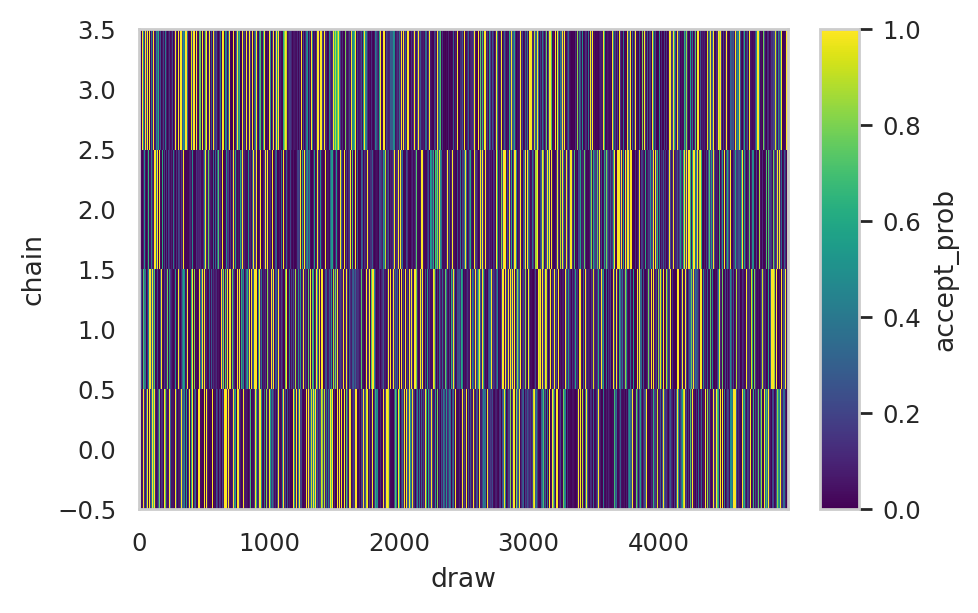

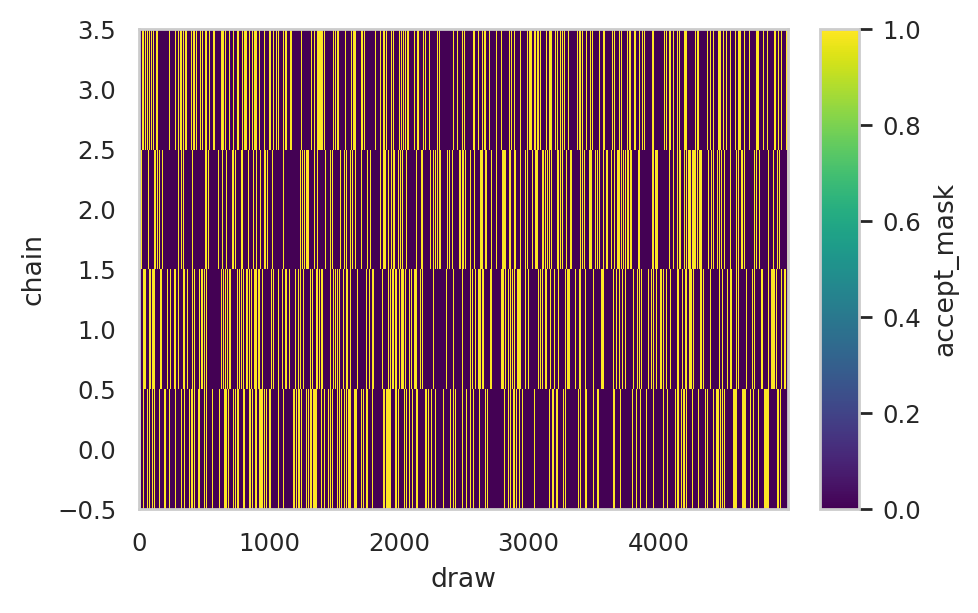

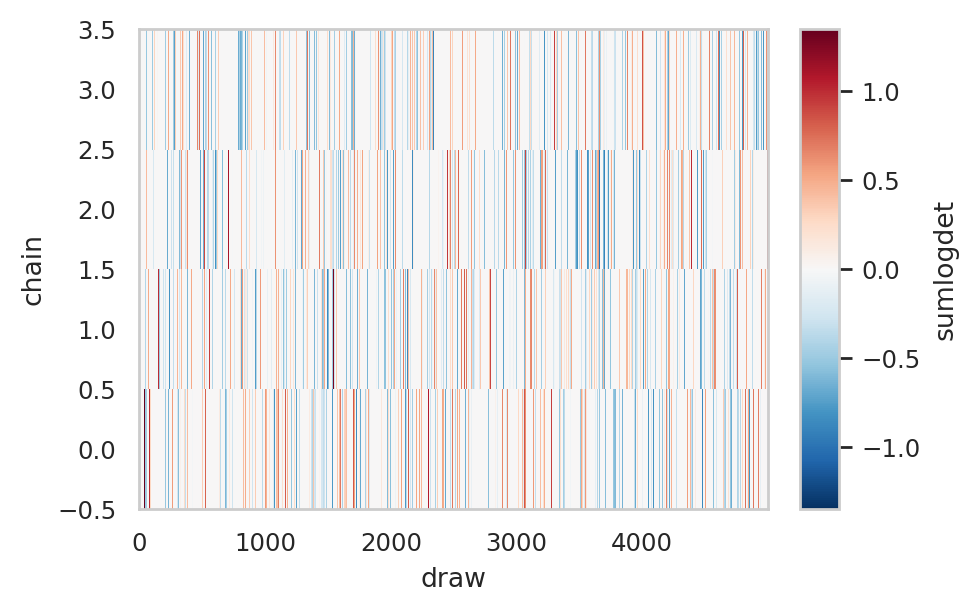

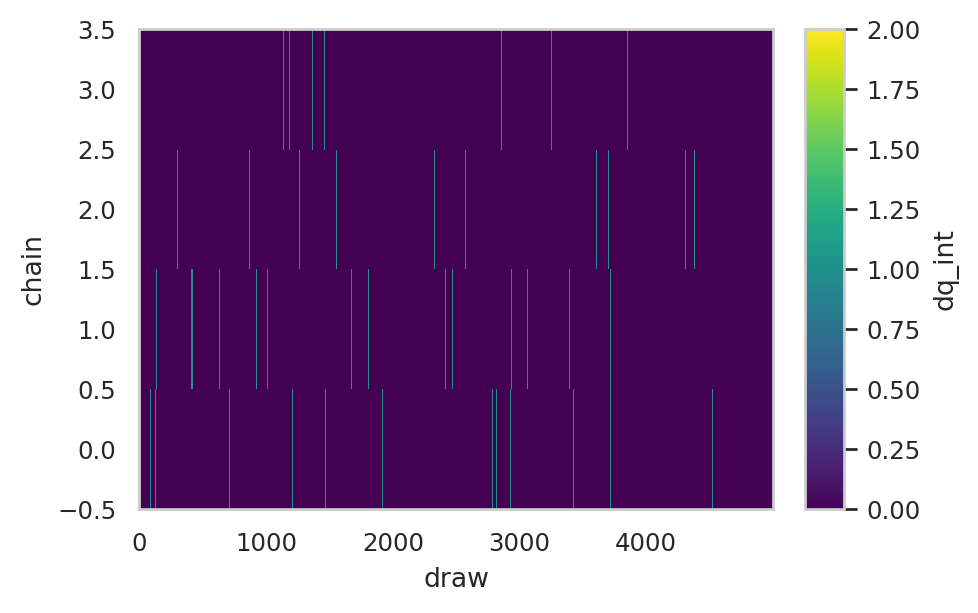

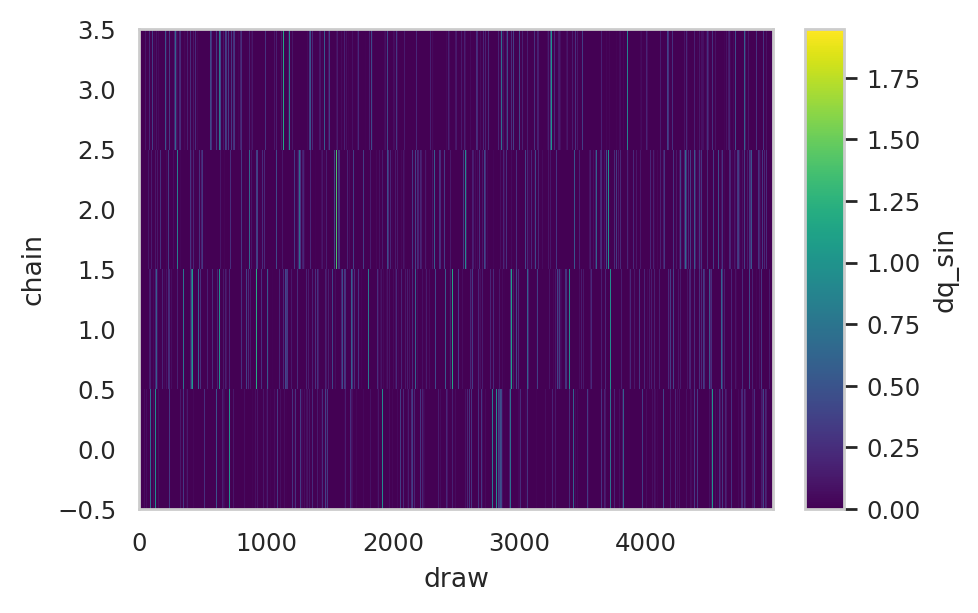

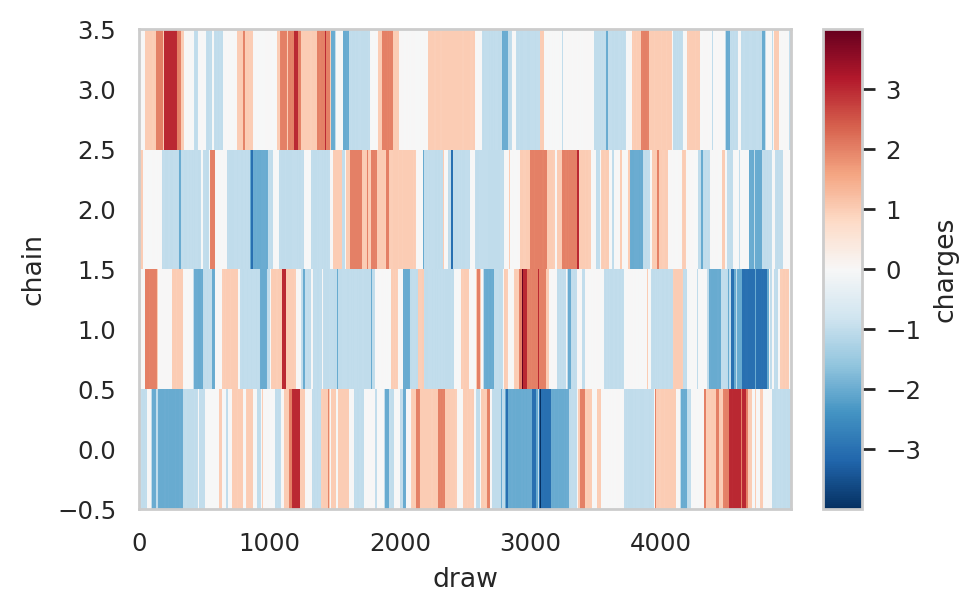

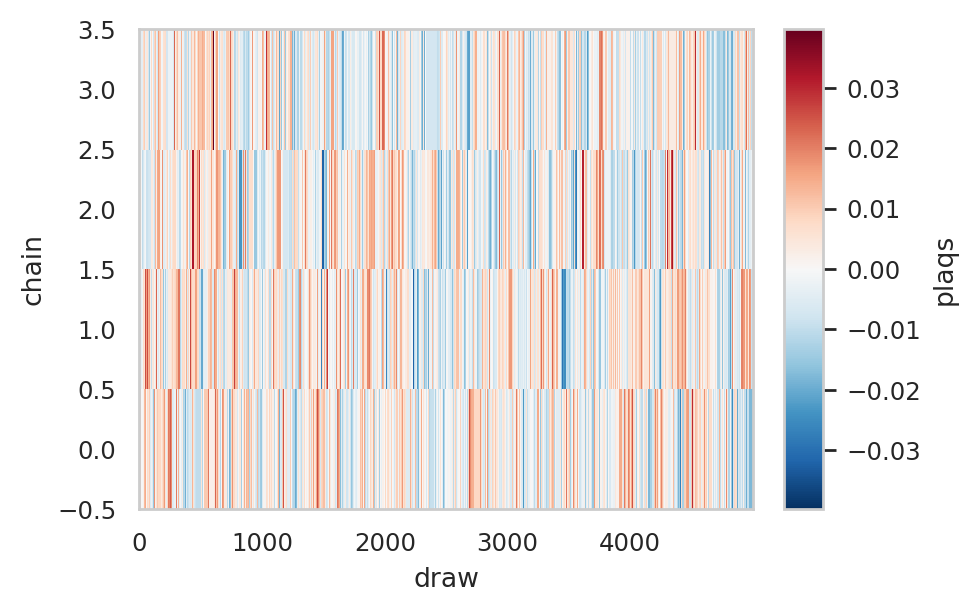

In [15]:
from utils.plotting_utils import set_size, make_ridgeplots

num_chains_to_plot = 4 

to_plot = [
    'plaqs', 'p4x4'
    'loss', 'sumlogdet',
    'accept_prob', 'accept_mask',
    'charges', 'dq_int', 'dq_sin',
]


run_data = inference_results.run_data

run_dataset = run_data.get_dataset(therm_frac=0.)
for key, val in run_dataset.data_vars.items():
    if key not in to_plot:
        continue
        
    val = val[:num_chains_to_plot]
    fig, ax = plt.subplots(constrained_layout=True, figsize=set_size())
    _ = val.plot(ax=ax)

In [ ]:
# only make plots for 8 chains to speed up plotting
num_chains_to_plot = 64 

# draw initial x uniformly from [-pi, pi]:
x_shape = configs.dynamics_config.get('x_shape', none)
x = tf.random.uniform(x_shape, minval=-np.pi, maxval=np.pi)
x = tf.reshape(x, (x.shape[0], -1))

x, dynamics, train_data, configs = train(configs,
                                         x=x, make_plots=true,
                                         num_chains=num_chains_to_plot,
                                         should_track=false)

In [ ]:
num_chains_to_plot = 16

run_dataset = inference_results.run_data.get_dataset(therm_frac=0.1)
for key, val in run_dataset.data_vars.items():
    if key not in to_plot:
        continue
        
    val = val[:num_chains_to_plot]
    fig, ax = plt.subplots(constrained_layout=True, figsize=set_size())
    _ = val.plot(ax=ax)
    
_ = make_ridgeplots(run_dataset, num_chains_to_plot)